In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv', 'data_description.txt']


In [2]:
#Drop ID as we dont need it for now

train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
train.head()
train_id = train['Id']
test_id = test['Id']
for i in [train,test]:
    i.drop('Id',inplace=True,axis=1)

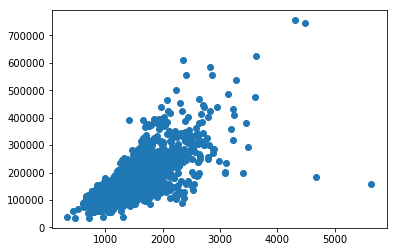

In [3]:
#Checking and removing outliers for GrLivArea
plt.scatter(x=train['GrLivArea'],y=train['SalePrice'])
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

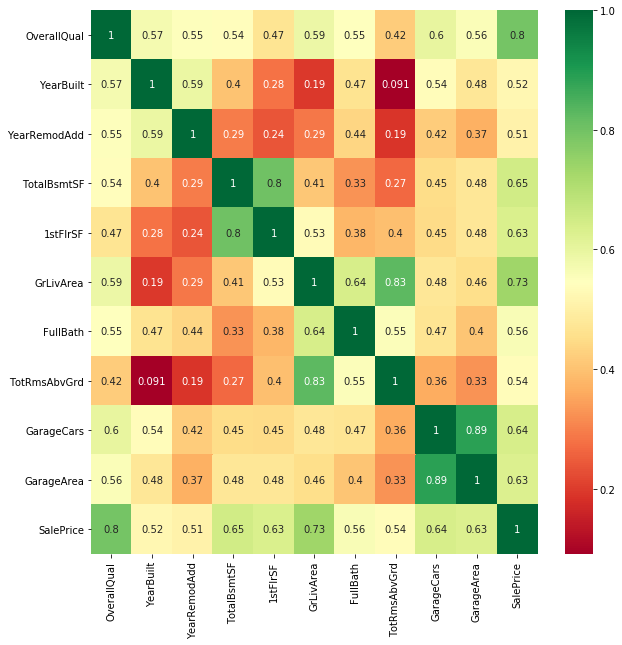

In [4]:
corrmat = train.corr()
top_f = corrmat.index[abs(corrmat['SalePrice'])>0.5]
top_f
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_f].corr(),annot=True,cmap="RdYlGn")

We can see that features(OverallQual,GrLivArea and TotalBsmtSF) are highly correlated to sales price.
GarageCars and GarageArea also seems to be correlated

In [5]:
train.skew()

MSSubClass        1.407011
LotFrontage       1.543043
LotArea          12.573925
OverallQual       0.200786
OverallCond       0.691035
YearBuilt        -0.612295
YearRemodAdd     -0.501838
MasVnrArea        2.687784
BsmtFinSF1        0.764789
BsmtFinSF2        4.251925
BsmtUnfSF         0.920903
TotalBsmtSF       0.511703
1stFlrSF          0.887637
2ndFlrSF          0.812957
LowQualFinSF      9.004955
GrLivArea         1.010992
BsmtFullBath      0.590358
BsmtHalfBath      4.100114
FullBath          0.031271
HalfBath          0.680051
BedroomAbvGr      0.212325
KitchenAbvGr      4.484883
TotRmsAbvGrd      0.660502
Fireplaces        0.632060
GarageYrBlt      -0.648137
GarageCars       -0.342377
GarageArea        0.131748
WoodDeckSF        1.545805
OpenPorchSF       2.339829
EnclosedPorch     3.087164
3SsnPorch        10.297106
ScreenPorch       4.118929
PoolArea         15.948945
MiscVal          24.460085
MoSold            0.215432
YrSold            0.095420
SalePrice         1.881296
d

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180932.92 and sigma = 79467.79



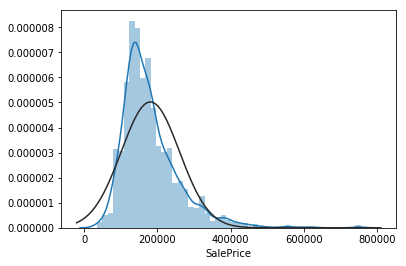

In [6]:
#Function to check the skewness of the data
def checkskew(col):
    sns.distplot(train[col],fit=norm)
    (mu, sigma) = norm.fit(train[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
checkskew('SalePrice')

Now we'll correct this skewness

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 12.02 and sigma = 0.40



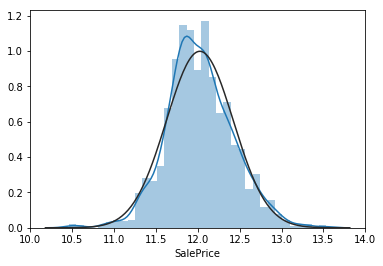

In [7]:
train['SalePrice'] = np.log1p(train['SalePrice'])
checkskew('SalePrice')

**MISSING DATA**


In [8]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

data = pd.concat((train,test)).reset_index(drop=True)
data.drop('SalePrice',axis=1,inplace=True)
data

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,NaN,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,NaN,0,2,CollgCr,61,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,NaN,TA,1,CBlock,2,Typ,460.0,2.0,TA,RFn,TA,Attchd,1976.0,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.0,Reg,0,20,RL,0.0,None,NaN,0,5,Veenker,0,8,6,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,608.0,2.0,TA,RFn,TA,Attchd,2001.0,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,NaN,0,9,CollgCr,42,5,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,NaN,Gd,1,BrkTil,1,Typ,642.0,3.0,TA,Unf,TA,Detchd,1998.0,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60.0,IR1,0,70,RL,0.0,None,NaN,0,2,Crawfor,35,5,7,Y,0,NaN,CompShg,Gable,Abnorml,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,836.0,3.0,TA,RFn,TA,Attchd,2000.0,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,NaN,0,12,NoRidge,84,5,8,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
5,796,566,320,NaN,1,1Fam,TA,No,732.0,0.0,GLQ,Unf,1.0,0.0,Gd,64.0,Y,Norm,Norm,SBrkr,0,TA,TA,VinylSd,VinylSd,MnPrv,NaN,0,Wood,1,Typ,480.0,2.0,TA,Unf,TA,Attchd,1993.0,1362,1,GasA,Ex,1.5Fin,1,TA,Lvl,Gtl,14115,Inside,85.0,IR1,0,50,RL,0.0,None,Shed,700,10,Mitchel,30,5,5,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,5,796.0,AllPub,40,1993,1995,2009
6,1694,0,0,NaN,3,1Fam,TA,Av,1369.0,0.0,GLQ,Unf,1.0,0.0,Ex,317.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,Gd,1,PConc,2,Typ,636.0,2.0,TA,RFn,TA,Attchd,2004.0,1694,0,GasA,Ex,1Story,1,Gd,Lvl,Gtl,10084,Inside,75.0,Reg,0,20,RL,186.0,Stone,NaN,0,8,Somerst,57,5,8,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,7,1686.0,AllPub,255,2004,2005,2007
7,1107,983,0,NaN,3,1Fam,TA,Mn,859.0,32.0,ALQ,BLQ,1.0,0.0,Gd,216.0,Y,PosN,Norm,SBrkr,228,TA,TA,HdBoard,HdBoard,NaN,TA,2,CBlock,2,Typ,484.0,2.0,TA,RFn,TA,Attchd,1973.0,2090,1,GasA,Ex,2Story,1,TA,Lvl,Gtl,10382,Corner,NaN,IR1,0,60,RL,240.0,Stone,Shed,350,11,NWAmes,204,6,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,7,1107.0,AllPub,235,1973,1973,2009
8,1022,752,0,NaN,2,1Fam,TA,No,0.0,0.0,Unf,Unf,0.0,0.0,TA,952.0,Y,Artery,Norm,FuseF,205,TA,TA,BrkFace,Wd Shng,NaN,TA,2,BrkTil,2,Min1,468.0,2.0,TA,Unf,Fa,Detchd,1931.0,1774,0,GasA,Gd,1.5Fin,2,TA,Lvl,Gtl,6120,Inside,51.0,Reg,0,50,RM,0.0,None,NaN,0,4,OldTown,0,5,7,Y,0,NaN,CompShg,Gable,Abnorml,WD,0,Pave,8,952.0,AllPub,90,1931,1950,2008
9,1077,0,0,NaN,2,2fmCon,TA,No,851.0,0.0,GLQ,Unf,1.0,0.0,TA,140.0,Y,Artery,Artery,SBrkr,0,TA,TA,MetalSd,MetalSd,NaN,TA,2,BrkTil,1,Typ,205.0,1.0,

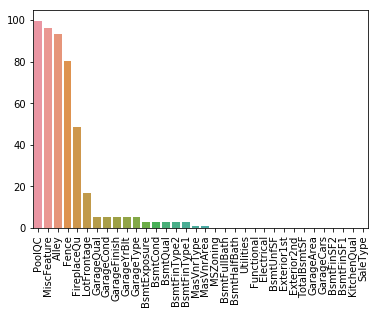

In [9]:
data_na = (data.isnull().sum() / len(data))*100
data_na = data_na.drop(data_na[data_na==0].index).sort_values(ascending=False)

plt.xticks(rotation='90')
sns.barplot(data_na.index,data_na)


In [10]:
data["PoolQC"] = data["PoolQC"].fillna("None")
data["MiscFeature"] = data["MiscFeature"].fillna("None")
data["Alley"] = data["Alley"].fillna("None")
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")
data["Fence"] = data["Fence"].fillna("None")
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    data[col] = data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)
data['LotFrontage'] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x:x.fillna(x.median()))
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])
data.drop('Utilities',inplace=True,axis=1)
data['Functional'] = data['Functional'].fillna('Typ')
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    data[col] = data[col].fillna(data[col].mode()[0])

In [11]:
#Check if any more null values is present or not
data.isnull().sum().sum()

0

In [12]:
data.shape

(2917, 78)

In [13]:
#Now we want to convert the non-ordinal numerical data to string
data['MSSubClass'] = data['MSSubClass'].apply(str)
data['OverallCond'] = data['OverallCond'].astype(str)

In [14]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for i in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[i].values)) 
    data[i] = lbl.transform(list(data[i].values))

# shape        
print('Shape all_data: {}'.format(data.shape))

Shape all_data: (2917, 78)


In [15]:
#Make one more new coloumn
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

In [16]:
#get all numeric data 
num = data.dtypes[data.dtypes != 'object'].index
skew_f = data[num].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed = pd.DataFrame({'Skew':skew_f})
skewed

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [17]:
skewed = skewed[abs(skewed) > 0.75]
from scipy.special import boxcox1p
skewed_features = skewed.index
lam = 0.15
for feat in skewed_features:
    data[feat] = boxcox1p(data[feat], lam)

In [18]:
data = pd.get_dummies(data)
data.shape

(2917, 220)

In [19]:
train = data[:ntrain]
test = data[ntrain:]
train.shape

(1458, 220)

Modelling

In [20]:
#First we'll make a validation fucntion
#We'll use K-Fold Cross Validation

n_folds=4
def vf(m):
    kf = KFold(n_folds,shuffle=True,random_state=12).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(m, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


Ridge Regression

In [21]:
rr = KernelRidge(alpha=0.6,kernel='polynomial',degree=2,coef0=2.5)
score = vf(rr)
print("Ridge Regression Score : {:.4f}".format(score.mean()))

Ridge Regression Score : 0.1141


In [22]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = vf(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1168 (0.0124)



In [23]:
RidgeMd = rr.fit(train.values,y_train)
GboostMd = GBoost.fit(train.values,y_train)

In [24]:
finalMd = (np.expm1(RidgeMd.predict(test.values)) + np.expm1(GboostMd.predict(test.values)) ) / 2
finalMd

array([121796.96764876, 175705.14331706, 184074.75269224, ...,
       167850.87498794, 112125.08884333, 219762.84826665])

In [25]:
ans = pd.DataFrame()
ans['Id'] = test_id
ans['SalePrice'] = finalMd
ans.to_csv('submission.csv',index=False)